<a href="https://colab.research.google.com/github/lordcrawford/cs230_genaifakes/blob/main/EFFICIENTB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 129.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 174.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 133.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.0/225.0 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.5 MB/s eta 0:00:00


In [4]:
import numpy as np
import tensorflow as tf

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pietrob92/wild-in-the-wild-image-linkage-dataset")

print("Path to dataset files:", path)

100%|██████████| 47.5G/47.5G [20:51<00:00, 40.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1


Contents of the dataset directory:

Found 1000th image: /root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data/Post-Processed/Open_Set/Deep AI/PP/step3/img_178_step1_Resize_step2_Super_Resolution_step3_Greyscale.png


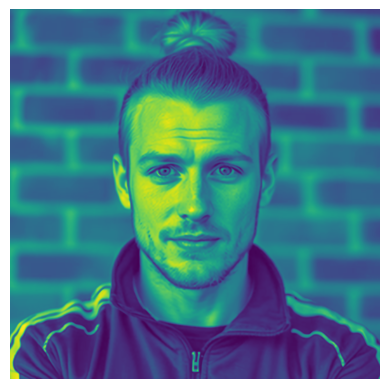

In [6]:
# THIS IS JUST TO SEE THE IMAGE

import os
from PIL import Image
import matplotlib.pyplot as plt

# Assuming the images are in a subdirectory within the downloaded path
# We need to find the actual path to the images.
# Let's list the contents of the downloaded path first to see the structure.
print("Contents of the dataset directory:")
image_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(root, file))

# Check if there are enough images
if len(image_files) >= 15000:
    image_path = image_files[49039] # Get the 1000th image (index 999)
    print(f"\nFound 1000th image: {image_path}")
    try:
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')  # Hide axes
        plt.show()
    except Exception as e:
        print(f"Error opening or displaying image: {e}")
else:
    print(f"\nOnly {len(image_files)} image files found in the dataset directory. Cannot display the 1000th image.")

In [7]:
import os
import numpy as np

# -------------------------------------------------------------------
# Root folder that contains 'Open_Set' and 'Closed_Set'
# -------------------------------------------------------------------
# `path` should already be defined from your kagglehub.dataset_download(...)
DATA_ROOT = os.path.join(path, "Data")

open_set_dir = os.path.join(DATA_ROOT, "Open_Set")
closed_set_dir = os.path.join(DATA_ROOT, "Closed_Set")

print("DATA_ROOT:", DATA_ROOT)
print("Open set dir:", open_set_dir)
print("Closed set dir:", closed_set_dir)

print("Does DATA_ROOT exist? ", os.path.isdir(DATA_ROOT))
print("Does Open_Set exist?  ", os.path.isdir(open_set_dir))
print("Does Closed_Set exist?", os.path.isdir(closed_set_dir))

# -------------------------------------------------------------------
# Helper: collect images per model (subfolder = model name)
# -------------------------------------------------------------------
def collect_images_per_model(root_dir):
    model_dict = {}

    if not os.path.isdir(root_dir):
        print(f"WARNING: {root_dir} does not exist or is not a directory.")
        return model_dict

    # Each immediate subfolder is assumed to be one AI model
    for model_name in os.listdir(root_dir):
        model_path = os.path.join(root_dir, model_name)
        if not os.path.isdir(model_path):
            continue

        for r, _, files in os.walk(model_path):
            for f in files:
                if f.lower().endswith((".png", ".jpg", ".jpeg")):
                    full_path = os.path.join(r, f)
                    model_dict.setdefault(model_name, []).append(full_path)

    return model_dict

# Collect from Closed_Set and Open_Set
closed_categorized = collect_images_per_model(closed_set_dir)
open_categorized   = collect_images_per_model(open_set_dir)

# -------------------------------------------------------------------
# Merge into a single dict: categorized_images[model_name] = list of paths
# -------------------------------------------------------------------
categorized_images = {}

# Add closed-set images
for model, paths in closed_categorized.items():
    categorized_images.setdefault(model, []).extend(paths)

# Add open-set images
for model, paths in open_categorized.items():
    categorized_images.setdefault(model, []).extend(paths)

# Summary
print("\n--- Image Categorization Summary (Open + Closed) ---")
total_imgs = 0
for model, paths in categorized_images.items():
    print(f"{model}: {len(paths)} images")
    total_imgs += len(paths)
print(f"Total images: {total_imgs}")
print(f"Total models: {len(categorized_images)}")
print("---------------------------------------------------")

# -------------------------------------------------------------------
# Create labels for all models
# -------------------------------------------------------------------
ai_model_names = list(categorized_images.keys())  # all models across open+closed
model_to_label = {model: i for i, model in enumerate(ai_model_names)}

print("\nModel to label mapping:")
for m, idx in model_to_label.items():
    print(f"  {idx}: {m}")

image_paths = []
labels = []

for model, paths in categorized_images.items():
    lbl = model_to_label[model]
    image_paths.extend(paths)
    labels.extend([lbl] * len(paths))

labels = np.array(labels)

print(f"\nTotal number of image paths: {len(image_paths)}")
print(f"Total number of labels: {len(labels)}")
print(f"First 5 image paths: {image_paths[:5]}")
print(f"First 5 labels: {labels[:5]}")

DATA_ROOT: /root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data
Open set dir: /root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data/Open_Set
Closed set dir: /root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data/Closed_Set
Does DATA_ROOT exist?  True
Does Open_Set exist?   True
Does Closed_Set exist? True

--- Image Categorization Summary (Open + Closed) ---
Flux.1: 1000 images
Flux.1.1 Pro: 1000 images
Midjourney: 1000 images
Leonardo AI: 1000 images
Stable Diffusion 3.5: 1000 images
Adobe Firefly: 1000 images
Stable Diffusion XL: 1000 images
Freepik: 1000 images
Dall-E 3: 1000 images
Starry AI: 1000 images
Nvidia Sana PAG: 1000 images
Stable Cascade: 1000 images
Dall-E 1: 1000 images
Hotpot AI: 1000 images
Tencent_Hunyuan: 1000 images
StyleGAN3: 1000 images
StyleGAN: 1000 images
Stable Diffusion Attend and Excite: 1000 images
StyleGAN2: 1000 images
Deep AI:

In [8]:
image_paths = []
labels = []

for model, paths in categorized_images.items():
    image_paths.extend(paths)
    label = model_to_label[model]
    labels.extend([label] * len(paths))

labels = np.array(labels)

print(f"Total number of image paths: {len(image_paths)}")
print(f"Total number of labels: {len(labels)}")
print(f"First 10 image paths: {image_paths[:10]}")
print(f"First 10 labels: {labels[:10]}")

Total number of image paths: 20000
Total number of labels: 20000
First 10 image paths: ['/root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data/Closed_Set/Flux.1/img_836.png', '/root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data/Closed_Set/Flux.1/img_122.png', '/root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data/Closed_Set/Flux.1/img_271.png', '/root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data/Closed_Set/Flux.1/img_235.png', '/root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data/Closed_Set/Flux.1/img_24.png', '/root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data/Closed_Set/Flux.1/img_951.png', '/root/.cache/kagglehub/datasets/pietrob92/wild-in-the-wild-image-linkage-dataset/versions/1/Data/Closed_Set/Flux.1/img_414.png', '/r

In [9]:
from sklearn.model_selection import train_test_split

train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

print(f"Number of training images: {len(train_image_paths)}")
print(f"Number of validation images: {len(val_image_paths)}")
print(f"Number of training labels: {len(train_labels)}")
print(f"Number of validation labels: {len(val_labels)}")

Number of training images: 16000
Number of validation images: 4000
Number of training labels: 16000
Number of validation labels: 4000


## Create a data generator

### Subtask:
Build a Keras `ImageDataGenerator` or a custom data generator to load and preprocess images in batches during training, utilizing the training and validation file paths and labels.


**Reasoning**:
Build a Keras `ImageDataGenerator` or a custom data generator to load and preprocess images in batches during training, utilizing the training and validation file paths and labels.



In [10]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

# Define image size and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Create ImageDataGenerators
# Rescale pixel values to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create training data generator
# Using flow_from_dataframe requires a DataFrame, let's create one from our lists

train_df = pd.DataFrame({'filename': train_image_paths, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_image_paths, 'class': val_labels})

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw', # Use 'raw' for numerical labels
    shuffle=True
)

# Create validation data generator
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw', # Use 'raw' for numerical labels
    shuffle=False # No need to shuffle validation data
)

# Calculate steps per epoch
train_steps_per_epoch = len(train_image_paths) // BATCH_SIZE
val_steps_per_epoch = len(val_image_paths) // BATCH_SIZE

print(f"Training steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps_per_epoch}")

Found 16000 validated image filenames.
Found 4000 validated image filenames.
Training steps per epoch: 500
Validation steps per epoch: 125


## Build the neural network model

### Subtask:
Define a basic convolutional neural network (CNN) using Keras.


**Reasoning**:
Define a basic convolutional neural network (CNN) using Keras Sequential model with convolutional, pooling, flatten, and dense layers.



In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D

# Define image size and batch size (copied from data generator cell 9GcB3DrwpTE1 to ensure availability)
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# The variable 'model_to_label' was not found, indicating a potential kernel state loss.
# Based on previous execution, there were 9 distinct AI models categorized.
# For robustness, you should ensure cells defining `model_to_label` are run prior.
# Temporarily setting num_classes to 9 based on prior notebook output.
num_classes = len(model_to_label)
print("num_classes:", num_classes)

# Load the pre-trained EfficientNetB4 model
# Set include_top=False to remove the classification layer
base_model = tf.keras.applications.EfficientNetB4(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                                   include_top=False,
                                                   weights='imagenet')

# Freeze the base model layers so they are not trained
base_model.trainable = True

# Create a new model on top of the pre-trained base
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Use GlobalAveragePooling2D instead of Flatten for better performance with CNNs
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Print the model summary
model.summary()

num_classes: 20
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 4, 4, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,137,971 (69.19 MB)

 Trainable params: 18,012,764 (68.71 MB)

 Non-trainable params: 125,207 (489.09 KB)

## Compile the model

### Subtask:
Configure the model for training by specifying the optimizer, loss function, and metrics.


**Reasoning**:
Compile the defined Keras model with the specified optimizer, loss function, and metrics.



In [12]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.


## Train the model

### Subtask:
Train the neural network using the data generator for the training and validation data.


**Reasoning**:
Train the compiled Keras model using the data generators for the specified number of epochs, storing the training history.



In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,  # Set the number of epochs
    validation_data=val_generator,
    validation_steps=val_steps_per_epoch
)

print("Model training complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 479s 878ms/step - accuracy: 0.5578 - loss: 1.4106 - val_accuracy: 0.0500 - val_loss: 3.9930
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 437s 874ms/step - accuracy: 0.8793 - loss: 0.3771 - val_accuracy: 0.1035 - val_loss: 4.5779
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 435s 868ms/step - accuracy: 0.9277 - loss: 0.2256 - val_accuracy: 0.0597 - val_loss: 6.9866
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 437s 873ms/step - accuracy: 0.9506 - loss: 0.1605 - val_accuracy: 0.0510 - val_loss: 7.2219
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 437s 872ms/step - accuracy: 0.9515 - loss: 0.1491 - val_accuracy: 0.0500 - val_loss: 14.7190
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 437s 872ms/step - accuracy: 0.9652 - loss: 0.1140 - val_accuracy: 0.0500 - val_loss: 10.6912
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 436s 871ms/step - accuracy: 0.9711 - loss: 0.0908 - val_accuracy: 0.0505 - val_loss: 8.5506
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 437s 873ms/step - accuracy: 0.9744

**Reasoning**:
The task is to add a new column named `total_amount` to the DataFrame by summing the values in the `amount` column across all existing columns. I will use the `sum` method along the axis 1 to achieve this.



In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator, steps=val_steps_per_epoch)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")